# MPlot

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)

In [1]:
#| export
# Configuration paramaters
print_flag                    = True
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1

In [2]:
print("--- Check parameters ---")
print(
    "print_flag (for printing or not messages):", print_flag, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
print_flag (for printing or not messages): True 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [4]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f6a01f9bc40>

















## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [5]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [6]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [7]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [8]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [9]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_PulsusParadoxus"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: _MPlot_PulsusParadoxus
alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (1, 100)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None


In [10]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [11]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [12]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [1, 100]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None
---> W&B Train Artifact


### Transform to dataframe

In [13]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [14]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(17521, 1)


<bound method NDFrame.head of                             0
1970-01-01 00:00:00 -1.193829
1970-01-01 00:00:01 -1.193829
1970-01-01 00:00:02 -1.193829
1970-01-01 00:00:03 -1.262998
1970-01-01 00:00:04 -1.286055
...                       ...
1970-01-01 04:51:56  0.601779
1970-01-01 04:51:57  0.475591
1970-01-01 04:51:58  0.475591
1970-01-01 04:51:59  0.297443
1970-01-01 04:52:00  0.119295

[17521 rows x 1 columns]>

df_train ~  (17521, 1)
window_sizes =  [1, 100]
wlen =  100


## Check the MatrixProfile

In [15]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 0
GPU | Used mem: 24
GPU | Memory Usage: [--------------------] 0%


### Initialize parameters

In [16]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [17]:
# Use step for selecting values in position k*step 
ts_step = 1
ts = df_train.iloc[:, 0].values[::ts_step] #For some reason. Trying to follow MPlot-figures-ref

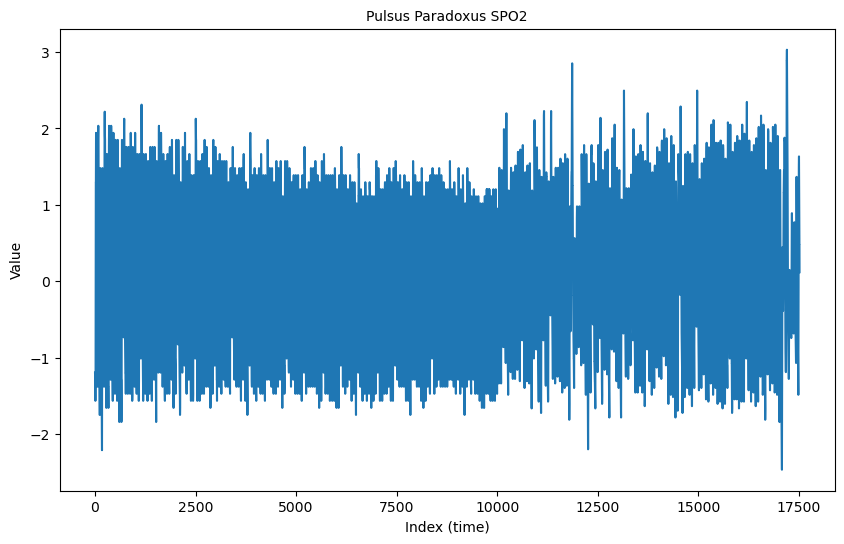

In [18]:
mplots.plot_with_dots(
    time_series = ts, 
    title = "Pulsus Paradoxus SPO2", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False
)

### Build the MatrixProfile object

In [19]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [20]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[27]

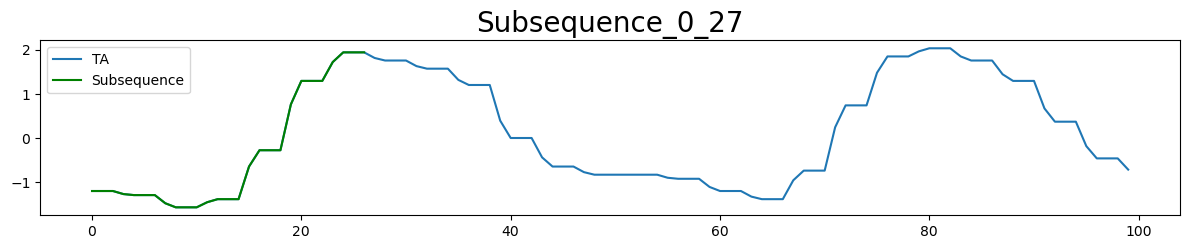

In [21]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = pulsus_mp.dominant_lens[0],
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

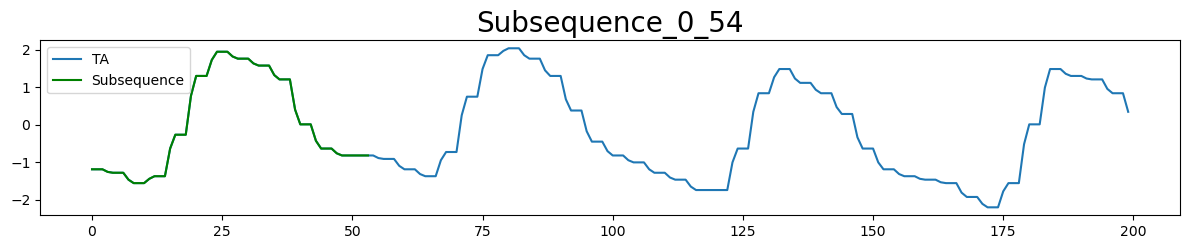

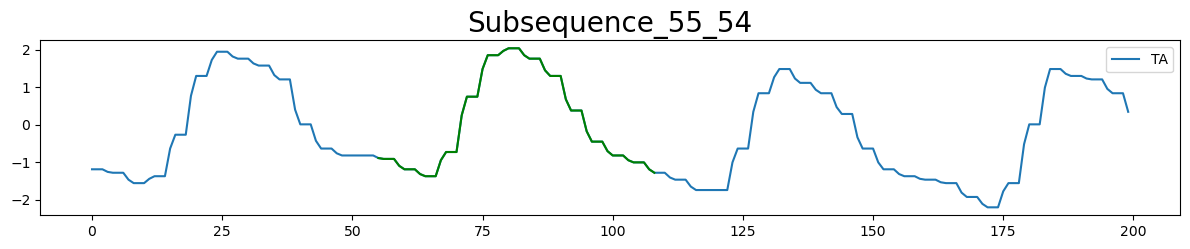

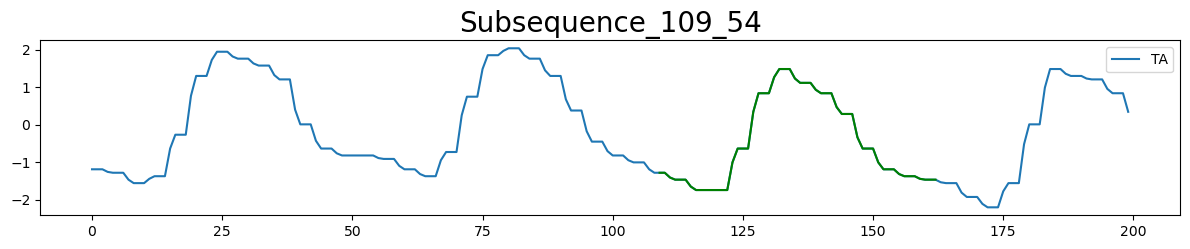

In [22]:
m = pulsus_mp.dominant_lens[0]*2
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [ ]:
pulsus_mp.compute(
    print_flag = True, 
    d = euclidean_distance, 
    method = 'stump'
)

--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? False


In [ ]:
len(pulsus_mp.index)

With the interactive plot we can visually check the motif and anomaly indexes.

In [ ]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    print_flag =  True
)

## Compute the MPlot

In [ ]:
len(ts)

In [ ]:
pulsus_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [ ]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

In [ ]:
len(pulsus_MPlot.data_b)

In [ ]:
max_points = 5000
min_position = 0

In [ ]:
pulsus_MPlot.compute(
    mp_method           = 'stump', 
    #mp_method           = "scamp_naive" --> Devuelve siempre 0 en el ejemplo de Pulsus Raxodus | why?
    #dm_method           = 'stump',
    dm_method           = 'scamp',
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    #c_min               = c_min,
    #c_max               = c_max,
    #r_min               = r_min, 
    #r_max               = r_max,
    max_points          = max_points,
    #nlens              = 5,
    subsequence_len     = 50, #1 heartbeat
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
print(pulsus_MPlot.DM_AB.shape)
print(pulsus_MPlot.DM_AB.method)

In [ ]:
print(len(ts))
print(len(pulsus_MPlot.MP_AB.distances))
print(pulsus_MPlot.MP_AB.distances)
print(pulsus_MPlot.DM_AB.distances)
print(pulsus_MPlot.mp_method)

In [ ]:
#| hide
print("MP_AB self_join", pulsus_MPlot.MP_AB.self_join)
print("DM_AB self_join", pulsus_MPlot.DM_AB.self_join)
print(f"DM_AB ~ {pulsus_MPlot.DM_AB.shape}")
print("MP_AB method:", pulsus_MPlot.MP_AB.method)
print("DM_AB method:", pulsus_MPlot.DM_AB.method)

In [ ]:
pulsus_MPlot.DM_AB.distances.shape

Observando en [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view) hay un motif de longitud 187 en aproximadamente la posicion:

In [ ]:
fraction = 205000/4
print(fraction)
approximated_position_in_eamonn_plot = fraction + (2 * fraction / 3)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

In [ ]:
#plot_numpy_array(ts[81000:102500], figsize = (30,5))
#plot_numpy_array(ts[data_MPlot.x_min:data_MPlot.x_max], figsize = (15,5))
#plot_numpy_array(ts, figsize = (10,5))
plt.close('all')
mplots.plot_with_dots(
    time_series   = ts[0:27*2], 
    title         = "Pulsus Paradoxus SPO2", 
    sequence_flag = False, 
    fontsize      = 10,
    dots          = False,
    figsize       = (8,4),
    save_plot     = True,
    plot_path     = "./images"
)

In [ ]:
%matplotlib widget
#data_MPlot.MP_AB.max_points = 100+data_MPlot.subsequence_len
max_points = 3000
print(f"Max points: {max_points}")
pulsus_MPlot.MP_AB.max_points = max_points
pulsus_MPlot.MP_AB.plot_interactive(print_flag = True, figsize=(8,6))

In [ ]:
threshold_scamp = 10
threshold_stump = 7.5
threshold = threshold_stump if pulsus_MPlot.DM_AB.method == 'stump' else threshold_scamp

In [ ]:
print(threshold)
pulsus_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = threshold,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'Variable 0: MPlot | ' + pulsus_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = False
)

In [ ]:
#Pattern location following Eamonn et al.
c_min = int(np.floor(10000/ts_step))
c_max = min(int(np.ceil(12000/ts_step))+1, pulsus_MPlot.DM_AB.shape[1])
r_min = max(0,int(np.floor(0/ts_step)))
r_max = min(int(np.ceil(2000/ts_step))+1, pulsus_MPlot.DM_AB.shape[0])

print(f"R({r_min}, {r_max}) C({c_min}, {c_max}) ")
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = r_min,
    r_max        = r_max,
    c_min        = c_min,
    c_max        = c_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 1
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print("Threshold: ", threshold)
pulsus_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = r_min,
    r_max        = r_max,
    c_min        = c_min,
    c_max        = c_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    print_depth  = 1
)

# And what about computing only the part of the plot I need?

In [ ]:
pulsus_MPlot2 = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
pulsus_MPlot2.compute(
    mp_method           = 'stump', 
    #mp_method           = "scamp_naive" --> Devuelve siempre 0 en el ejemplo de Pulsus Raxodus | why?
    #dm_method           = 'stump',
    dm_method           = 'scamp',
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    c_min               = r_min,
    c_max               = r_max,
    r_min               = c_min, 
    r_max               = c_max,
    max_points          = max_points,
    #nlens              = 5,
    subsequence_len     = 50, #1 heartbeat
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print(pulsus_MPlot.DM_AB.shape)
print(pulsus_MPlot2.DM_AB.shape)

In [ ]:
warnings.simplefilter('always', UserWarning)

In [ ]:
# The mistery of indexes is still being solved
print("Threshold: ", threshold)
pulsus_MPlot2.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = c_min,
    r_max        = c_max,
    c_min        = r_min,
    c_max        = r_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    print_depth  = 1
)

In [ ]:
run.finish

In [ ]:
if reset_kernel:
    os._exit(00)